In [33]:
#USE A RECURRENT NEURAL NETWORK
#https://www.tensorflow.org/text/tutorials/text_classification_rnn
#code from TensorFlow tutorials
#TODO: adapt to use simple tweet data rather than pre-built TF datasets

In [77]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [101]:
#plotting function
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [78]:
#load the data
import os
import pandas as pd

data_path = '/Users/jacksonwalters/tensorflow_datasets/'
file_path = 'labeled_tweets/all_labeled_tweets.txt'

df_tweet = pd.read_csv(data_path+file_path, names=['sentence', 'label'], sep='\t')
print(df_tweet.iloc[0])

sentence    Tune in 11:30 ET tomorrow for a live webcast o...
label                                                       0
Name: 0, dtype: object


In [79]:
#vectorize the data and split into train/test
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

tokenizer = Tokenizer(num_words=5000)
#get sentences
sentences = df_tweet['sentence'].values
#tweet sentence sentiment labels. 0 = negative, 1 = positive
y = df_tweet['label'].values
#split the sentences into training data and test data
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)
#vectorize the sentences
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1 
#pad_sequences
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [80]:
X_train[0]

array([3308,   35,  608,   11,   53,  190,    3,   11,  878,   58,   33,
         17, 2798,  498,    6,   13, 1332,  156,  134,   77,    7,  147,
        348,    1, 1781,   35,   19,   21,  339,   11,   18,    8,    9,
         10, 1064,    8,    9,   10,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [262]:
from keras import Sequential
from keras import layers

#define the model using Keras
#optionally add or remove LSTM layers using return_sequences=True
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           input_length=maxlen,
                           output_dim=64 
                            ))
model.add(layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

#compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
#summarize the model
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 100, 64)           1242560   
                                                                 
 bidirectional_27 (Bidirecti  (None, 128)              66048     
 onal)                                                           
                                                                 
 dense_50 (Dense)            (None, 64)                8256      
                                                                 
 dense_51 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,316,929
Trainable params: 1,316,929
Non-trainable params: 0
_________________________________________________________________


In [263]:
#train the model and plot training history
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/5


2022-01-16 23:38:01.939213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-16 23:38:02.230163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-16 23:38:02.240668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-16 23:38:02.564254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-16 23:38:02.578971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


905/905 [==============================] - ETA: 0s - loss: 0.6685 - accuracy: 0.5312

2022-01-16 23:39:00.425705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-16 23:39:00.532879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-16 23:39:00.540502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


905/905 [==============================] - 66s 71ms/step - loss: 0.6685 - accuracy: 0.5312 - val_loss: 0.5170 - val_accuracy: 0.7765
Epoch 2/5
905/905 [==============================] - 62s 68ms/step - loss: 0.2395 - accuracy: 0.9006 - val_loss: 0.1792 - val_accuracy: 0.9343
Epoch 3/5
905/905 [==============================] - 63s 69ms/step - loss: 0.1335 - accuracy: 0.9474 - val_loss: 0.1315 - val_accuracy: 0.9469
Epoch 4/5
905/905 [==============================] - 63s 70ms/step - loss: 0.0957 - accuracy: 0.9627 - val_loss: 0.1121 - val_accuracy: 0.9582
Epoch 5/5
905/905 [==============================] - 63s 70ms/step - loss: 0.0774 - accuracy: 0.9706 - val_loss: 0.1141 - val_accuracy: 0.9499


Training Accuracy: 0.9627
Testing Accuracy:  0.9499


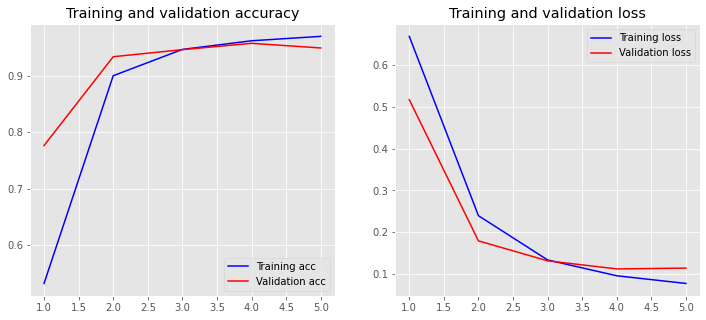

In [264]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [276]:
#sample predictions on trained model
sample_text = 'mike pence'
X_ex_sent = tokenizer.texts_to_sequences([sample_text])
model.predict(pad_sequences(X_ex_sent, padding='post', maxlen=maxlen))

array([[0.4204297]], dtype=float32)

In [178]:
df_tweet[:20]

,sentence,label
0,Tune in 11:30 ET tomorrow for a live webcast o...,0
1,"Iowans, there's a good chance there's a Biden ...",0
2,We're excited to announce that @JoeBiden is be...,0
3,Campaign staff will run this account to keep y...,0
4,News for you this morning: VP Biden will speak...,0
5,"In NH on 4/12, the Vice President will give hi...",0
6,I’m for the Buffett Rule because it just makes...,0
7,"During a recent campaign stop in Ohio, VP Bide...",0
8,"Favorite Joe photos, volume 1: http://t.co/Xt0...",0
9,The VP will be speaking in NH on Thursday abou...,0
